TODO

add description

add exercise

add references

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

Time series multivariate forecasting can be achieved using machine learning models, such as: linear regression for regression problems or SVM, decision tree for classification problems.

For this example, we are going to use ```Beijing PM2.5 Dataset```. The dataset contains hourly data of the PM2.5 colleted from US Embassy in Beijing. PM2.5 is a common measurement used to measures air quality. The dataset also include variable like dew point, temperature, pressure, wind direction, wind speed, and etc.

The objective of this tutorial is to forecast the PM2.5 value for the next day, which is the next 24 hours. By using machine learning models, we can treats dew point, temperature, pressure, and etc as our predictors and our target is the pm2.5 of the next day.

General benefits of machine learning algorithms for time series forecasting are:
- Ability to support multiple input features
- Ability to support noisy features and noise in the relationships between variables.
- Ability to handle irrelevant features.

Limitation of machine learning models is it can only make single-step prediction. For example if we have a model to predict the pm2.5 for the next hour, given the predictors for the current hour, it will predict the next hour, but it cant predict pm2.5 for the next two hour, unless the predictors for the next hour is given. This limit us to only predict single step ahead.

To solve this problem, we can build multiple models. let say we want predict next 24 hours, we would have 24 models, each model is build to predict each time step. 
	
more about the dataset: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data#

In [2]:
air = pd.read_csv('../datasets/multivariate/PRSA_data_2010.1.1-2014.12.31.csv')
air.index = pd.to_datetime(air[['year', 'month', 'day', 'hour']])
air.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01 00:00:00,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


table above shows the summary of beijing air pollution dataset. ```pm2.5``` is the value of interest $y$, and ```dewp, temp, pres, cbwd, lwd, ls, lr``` are the predictors $x$.

## Descriptive Analysis

Before we start, lets quickly check the distribution, missing values, and unique values of our dataset

In [3]:
#remove unused column
air = air.drop("No", axis=1)

In [4]:
air.describe()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [5]:
air['pm2.5'].quantile(.95)

284.0

In [6]:
def get_missing_value_and_unique_count(dataframe):
    missing_value_count = dataframe.isna().sum()
    unique_count = dataframe.apply(lambda x: len(x.unique()))
    
    return pd.DataFrame({'missing_value': missing_value_count,'unique': unique_count})

In [7]:
# check missing values and unique count
get_missing_value_and_unique_count(air)

,missing_value,unique
year,0,5
month,0,12
day,0,31
hour,0,24
pm2.5,2067,582
DEWP,0,69
TEMP,0,64
PRES,0,60
cbwd,0,4
Iws,0,2788


In [8]:
air.apply(set)

year                        {2010, 2011, 2012, 2013, 2014}
month              {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
day      {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
hour     {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
pm2.5    {nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
DEWP     {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
TEMP     {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
PRES     {1024.0, 1025.0, 1026.0, 1027.0, 1028.0, 1029....
cbwd                                      {SE, NW, cv, NE}
Iws      {2.25, 4.91, 4.02, 6.25, 7.16, 8.93, 9.84, 8.5...
Is       {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Ir       {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
dtype: object

In [9]:
air = air[air['year']>=2012]

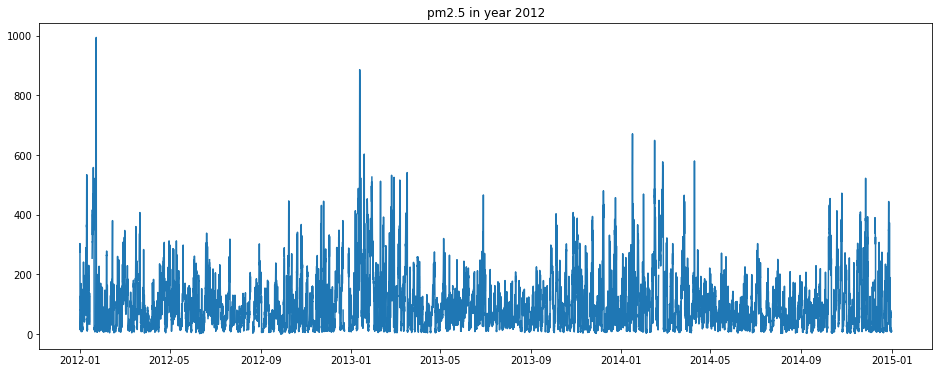

In [10]:

plt.rc('figure',figsize=(16,6))

plt.plot(air['pm2.5'])
plt.title("pm2.5 in year 2012")

plt.show()

## Outliers Handling

Cap value at 95% quantile (284.0)

In [11]:
air['pm2.5'] = air['pm2.5'].clip(0, 284.0)

## Impute Missing Values

Since there are missing values in ```pm2.5```, we can fill it with some value.

There are several ways to do a value imputation.

***Non-time-series specific method***

- Mean imputation
- Median imputation
- Mode imputation 
- Random sample imputation (replace missing values with observations randomly selected from the remaining (either of it or just some section of it)

*These method can be use if series has no trend and seasonality*

***Time-Series specific method***

- Last observation carried forward (LOCF)
- Next observation carried backward (NOCB)
- Linear interpolation or Spline interpolation

*Interpolation methods rely on the assumption that adjacent observations are similar to one another,  do not work well when this assumption is not valid, especially when the presence of strong seasonality*

Lets impute the missing value using LOCF

In [12]:
# imputation using LOCF
air['pm2.5'] = air['pm2.5'].fillna(method='ffill')
air['pm2.5'] = air['pm2.5'].fillna(method='bfill')

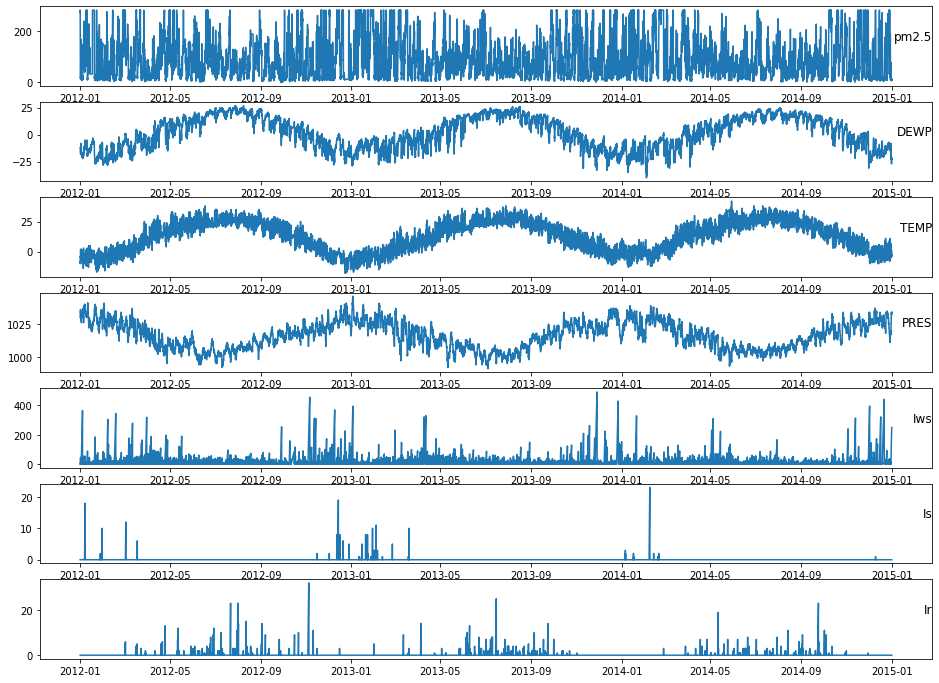

In [13]:
# specify columns to plot
groups = ['pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']
i = 1
# plot each column
plt.figure(figsize=(16,12))
for group in groups:
    series = air[group]
    plt.subplot(len(groups), 1, i)
    plt.plot(series)
    plt.title(series.name, y=0.5, loc='right')
    i += 1
    
plt.show()

## One Hot Encode Categorical Variable

The categorical variables we have here are ```cbwd, year, month, day, hour```. We will be using one hot encoding to represent the categorical variables into binary vectors. 

For example, categories in ```cbwd``` are ```NW, cv, NE, SE``` will be convert into binary vectors as below:

| NE | NW | SE | cv |
|---|---|---|---|
| 1 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 0 | 1 | 0 |
| 0 | 0 | 0 | 1 |

However to avoid **Dummy variable trap** which is the common problem in regression model, we have to remove any one of the encoded column. Hence the number of dummy variables necessary to represent a single attribute variable is equal to the number of categories in the variable minus one.

| NW | SE | cv |
|---|---|---|
| 1 | 0 | 0 |
| 0 | 1 | 0 |
| 0 | 0 | 1 |

In [14]:
cbwd_onehot = pd.get_dummies(air['cbwd'], prefix='cbwd', drop_first=True)

# hour_onehot = pd.get_dummies(air['hour'], prefix='hour', drop_first=True)
# month_onehot = pd.get_dummies(air['month'], prefix='month', drop_first=True)
# day_onehot = pd.get_dummies(air['day'], prefix='day', drop_first=True)

In [15]:
# air_combined = pd.concat([air, cbwd_onehot, month_onehot, day_onehot, hour_onehot], axis=1)

air_combined = pd.concat([air, cbwd_onehot], axis=1)
air_combined = air_combined.drop(['year','month','day','hour','cbwd'], axis=1)

In [16]:
air_combined.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
2012-01-01 00:00:00,275.0,-12,-8.0,1030.0,0.89,0,0,0,0,0
2012-01-01 01:00:00,284.0,-13,-10.0,1031.0,1.79,0,0,1,0,0
2012-01-01 02:00:00,215.0,-13,-9.0,1032.0,3.58,0,0,1,0,0
2012-01-01 03:00:00,222.0,-13,-9.0,1033.0,6.71,0,0,1,0,0
2012-01-01 04:00:00,85.0,-13,-4.0,1033.0,4.92,0,0,0,0,0


## Data Preparation 

Split data into train and test set for validation

In [17]:
# seperate dataset into train and test
test_index = air_combined.index>='2014-12-01'

air_train = air_combined[~test_index]
air_test = air_combined[test_index]


In this section, we adjust our dataset so it fits to supervised training requirement for 

In order to train the regression model for predicting ```pm2.5``` for next hour. we have to adjust our dataset so the predictor $x$ and interest value $y+1$ are in the same row.

In [18]:
def to_supervised(data, lags=1):
    X = data[:-lags,1:]
    y = data[lags:,0]
    return X, y

In [19]:
train_X, train_y = to_supervised(air_train.values, 1)
test_X, test_y = to_supervised(air_test.values, 1)

train_X[0], train_y[0]

(array([-1.20e+01, -8.00e+00,  1.03e+03,  8.90e-01,  0.00e+00,  0.00e+00,
         0.00e+00,  0.00e+00,  0.00e+00]), 284.0)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_X)
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

## Direct Single Step Predictions

In [21]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
lr = LinearRegression().fit(train_X_scaled, train_y)

In [23]:
lr.coef_

array([ 4.80146963e+01, -6.33967138e+01, -8.93523960e+00, -7.73994501e+00,
        2.75540085e-02, -7.39015745e+00, -2.73203472e+00,  1.65533115e+01,
        1.06522524e+01])

In [24]:
pred = lr.predict(test_X_scaled)
pred[:10]

array([27.25629128, 29.7650733 , 34.32850936, 39.06619934, 40.66703547,
       34.68941606, 32.40273586, 29.38595197, 26.94047453, 19.0480128 ])

In [25]:
mean_squared_error(pred, test_y)

3999.0082055982602

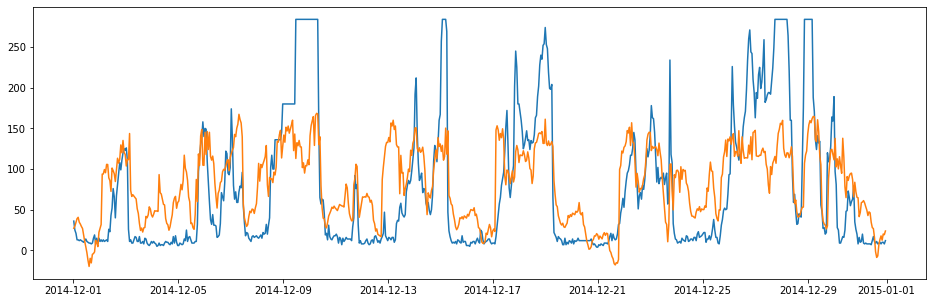

In [26]:
plt.figure(figsize=(16,5))

plt.plot(pd.Series(test_y, index=air_test[1:].index))
plt.plot(pd.Series(pred, index=air_test[1:].index))

In [27]:
svm = SVR().fit(train_X_scaled, train_y)

In [28]:
svm_pred = svm.predict(test_X_scaled)
svm_pred[:10]

array([13.32839639, 12.82182426, 12.59883759, 12.42856203, 12.46249352,
       12.64024482, 12.26194049, 12.35564507, 12.09990449, 12.20747063])

In [29]:
mean_squared_error(svm_pred, test_y)

3887.395064084896

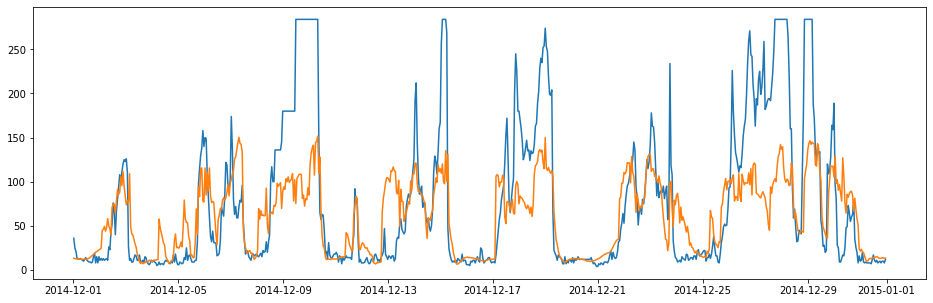

In [30]:
plt.figure(figsize=(16,5))

plt.plot(pd.Series(test_y, index=air_test[1:].index))
plt.plot(pd.Series(svm_pred, index=air_test[1:].index))

## Direct Multi Step Predictions

In [31]:
main_scaler = StandardScaler()
main_scaler.fit(air_train.iloc[:,1:].values)

StandardScaler(copy=True, with_mean=True, with_std=True)

training model for y(t+1), error: 3887.395064084896
training model for y(t+2), error: 4062.5059503093053
training model for y(t+3), error: 4311.031029248229
training model for y(t+4), error: 4516.980645666845
training model for y(t+5), error: 4686.42258791399
training model for y(t+6), error: 4902.856910385734
training model for y(t+7), error: 5131.823436093149
training model for y(t+8), error: 5366.219886248259
training model for y(t+9), error: 5557.520481744669
training model for y(t+10), error: 5691.180616442969
training model for y(t+11), error: 5783.802609773644
training model for y(t+12), error: 5882.162271981296


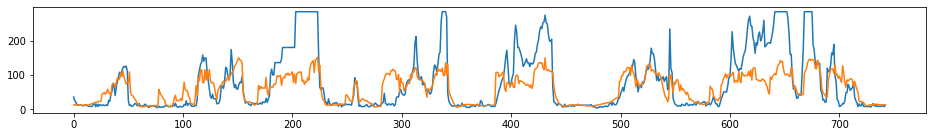

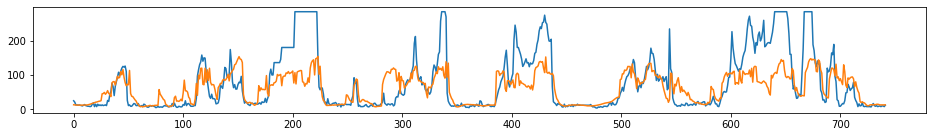

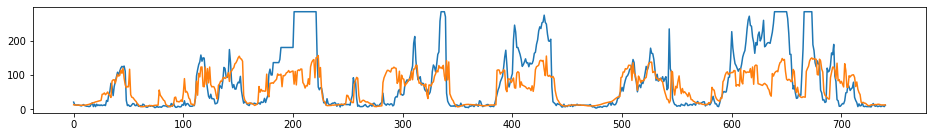

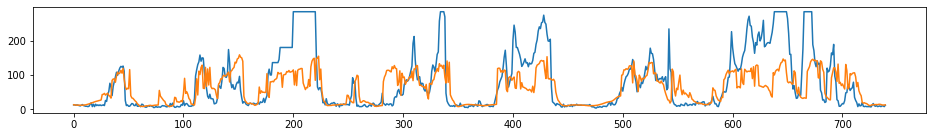

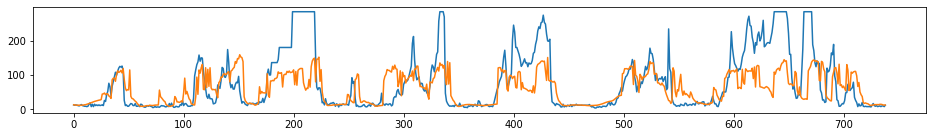

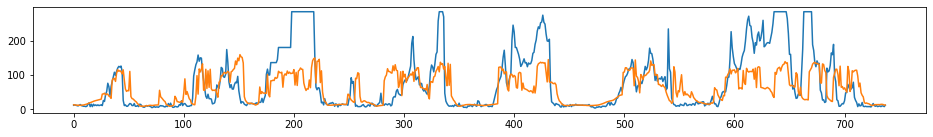

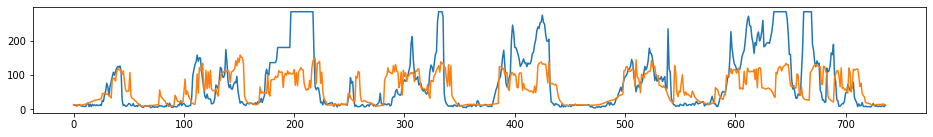

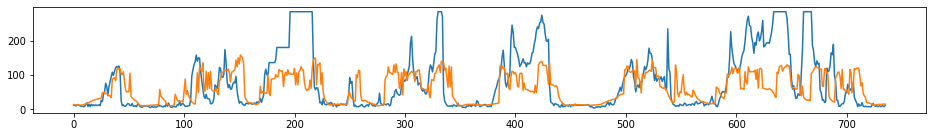

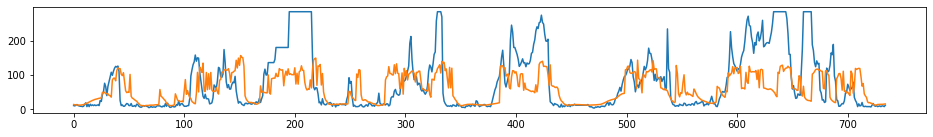

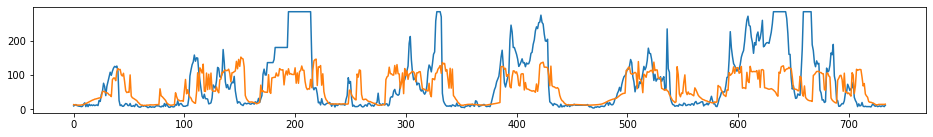

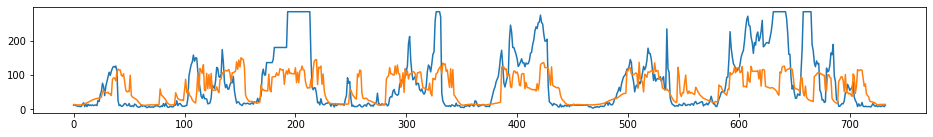

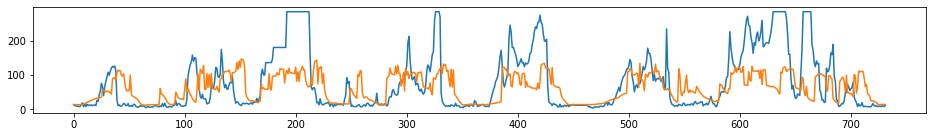

In [32]:
forecast_steps = 12

models = []
mses = []

for i in range(forecast_steps):
    step = i + 1
    train_X, train_y = to_supervised(air_train.values, step)
    test_X, test_y = to_supervised(air_test.values, step)
    
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)
    
    # training
    lr = SVR()
    lr.fit(train_X_scaled, train_y)
    
    pred = lr.predict(test_X_scaled)
    mse = mean_squared_error(pred, test_y)
    
    print('training model for y(t+{}), error: {}'.format(step, mse))
    
    mses.append(mse)
    models.append(lr)
    
#     plt.figure(figsize=(16,30))
#     plt.subplot(forecast_steps+1, 1, i+1)
#     plt.plot(test_y)
#     plt.plot(pred)

plt.show()

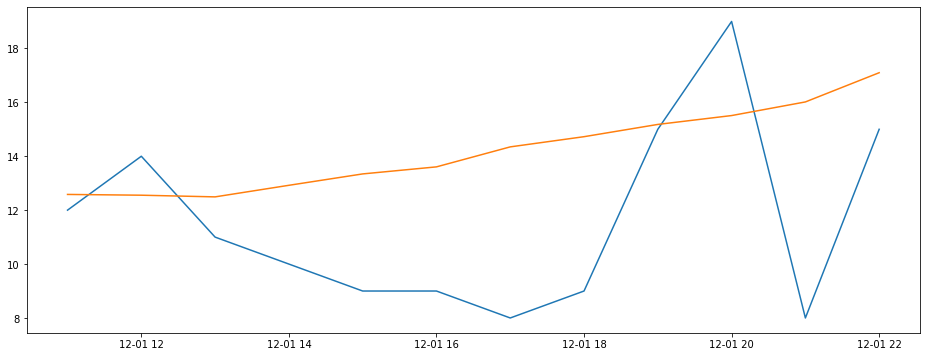

In [33]:
test_sample_index = 10
x_input = air_test.iloc[test_sample_index,1:]
x_input = main_scaler.transform(x_input.values.reshape(1,-1))

actual_output = air_test.iloc[test_sample_index+1:test_sample_index+13, 0]

pred_steps = []
for m in models:
    pred = m.predict(x_input)[0]
    pred_steps.append(pred)


plt.plot(actual_output)
plt.plot(pd.Series(pred_steps, index=actual_output.index))